In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

def display_img(file):
    img = mpimg.imread(file.file_path)
    imgplot = plt.imshow(img, cmap='gray')
    
def plot_hist(file, col_name, bins=55):
    df = pd.read_csv(file.file_path)
    plt.hist(df[col_name], bins=bins, edgecolor='black')
    plt.xlabel('Медиана интенсивности')
    plt.ylabel('Частота')
    plt.show()

In [ ]:
from cvlib import *
from files_manager import File, save_file

input_A = File(r'C:\Eyedisks\M1\-cSXL.tif')
input_B = File(r'C:\Eyedisks\M1\-cellmask.tif')
input_C = File(r'C:\Eyedisks\M1\rotate.txt')
input_D = File(r'C:\Eyedisks\M1\-apee-z.txt')
input_E = File(r'C:\Eyedisks\M1\crop-sm.txt')

output_A = r'C:\Eyedisks\M1\-SXL-ini.txt'
output_B = r'C:\Eyedisks\M1\-SXL-ini-mol.txt'
output_C = r'C:\Eyedisks\M1\-SXL-qnd.csv'
output_D = r'C:\Eyedisks\M1\-SXL-qnd-mol.csv'

In [ ]:
A = strel(window_height=23, window_width=23, shape=ShapeEnum.SQUARE)
B = strel3d(window_height=13, window_width=13, window_depth=3, shape_xy=ShapeEnum.SQUARE, shape_yz=ShapeEnum.SQUARE)
C = strel3d(window_height=5, window_width=5, window_depth=3, shape_xy=ShapeEnum.SQUARE, shape_yz=ShapeEnum.SQUARE)
D = strel(window_height=3, window_width=3, shape=ShapeEnum.SQUARE)
E = strel(window_height=3, window_width=3, shape=ShapeEnum.SQUARE)
F = vstrel(E[1])
G = turn3d(input_A + input_C)
H = apee3d(G[1] + input_D)
I = geometry3d(H[1] + input_E)

In [ ]:
J = lhbg(I[1] + A[1])
K = median3d(J[1] + B[1], repetitions=1)
L = vaff(K[1] + I[1], coeff_1=-1.0, coeff_2=1.0, coeff_3=0.0)
M = expand3d(L[1], scale_from_1=2.0)
N = hno(M[1])
O = invert3d(N[1])
P = gerosion3d(N[1] + C[1], repetitions=1)
Q = gerosion3d(O[1] + C[1], repetitions=1)
R = reconstruct3d(N[1] + P[1], connectivity=Connectivity3dEnum.TWENTY_SIX)
S = reconstruct3d(O[1] + Q[1], connectivity=Connectivity3dEnum.TWENTY_SIX)
T = invert3d(S[1])
U = mul3d(R[1] + T[1])
V = vaff(R[1] + T[1], coeff_1=-1.0, coeff_2=1.0, coeff_3=0.0)

In [ ]:
W = vmax(V[1] + U[1])
X = despekle3d(W[1], iterations=3)
Y = lhbg(X[1] + D[1])
Z = shrink3d(X[1], scale_from_0_to_1=0.5)

In [ ]:
BA = imcanny(Y[1], radius=0, sigma=1.2, low_frac=0.01, upper_frac='0.16')
display_img(BA[1])

In [ ]:
BB = chole(BA[1] + E[1])
BC = gopen(BB[1] + E[1], repetitions=1)
BD = distance(BC[1], window=DistanceTransformEnum.SEVEN)
BE = invert3d(BD[1])
BF = cwtsd(BE[1], connectivity=ConnectivityEnum.EIGHT)
BG = mul3d(BF[1] + BC[1])

In [ ]:
BH = sselect(BG[1] + F[1], max_segment=110, min_segment=20, rule=SselectRuleEnum.ACCEPT, criterion=0.13, connectivity=ConnectivityEnum.EIGHT)
BI = shrink3d(BH[1], scale_from_0_to_1=0.5)
BJ = qu3dinit(BI[1] + input_B, connectivity=Connectivity3dEnum.TWENTY_SIX, tag='nSXL')
BK = qu3dinit(Z[1] + BI[1], connectivity=Connectivity3dEnum.TWENTY_SIX, tag='SXLmol')
BL = qu3d(Z[1] + input_B + BJ[1], connectivity=Connectivity3dEnum.TWENTY_SIX, tag='cSXL')
BM = quremask(BI[1] + input_B + BK[1], connectivity=Connectivity3dEnum.TWENTY_SIX, tag='celnumber')
save_file(BL[1], output_A)
BN = qu3d2csv(BL[1])
BO = qu3d2csv(BM[1])
save_file(BM[1], output_B)
save_file(BN[1], output_C)
save_file(BO[1], output_D)

In [ ]:
plot_hist(BO[1], 'SXLmol_median', 66)

In [ ]:
df = pd.read_csv(BO[1].file_path)
for i in range(40, 100):
    plt.hist(df['SXLmol_median'], bins=i, edgecolor='black')
    plt.xlabel(f'Значение {i}')
    plt.ylabel('Частота')
    plt.show()

In [ ]:
import winsound
winsound.Beep(500, 1000)

# Этап 2

In [33]:
import cv2
import matplotlib.pyplot as plt
from ipywidgets import IntProgress

def find_mol_in_cells(need_recount=False):
    image = cv2.imread("-cellmask.png")
    df_mol = pd.read_csv(r"C:\Eyedisks\M1\-DI-qnd-mol.csv")

    # учет двойныйх моллекул
    df_mol['mol_count'] = 1
    if need_recount:
        df_mol.loc[df_mol['DImol_median'] > 42, 'mol_count'] = 2
        df_mol.loc[df_mol['DImol_median'] > 82.30117784664628, 'mol_count'] = 3

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    progress = IntProgress(min=0, max=len(contours))
    display(progress)

    results = {}

    for i, contour in enumerate(contours):
        moments = cv2.moments(contour)
        if moments['m00'] != 0:
            center_x = moments['m10'] / moments['m00']
            center_y = moments['m01'] / moments['m00']
            center = (center_x, center_y)

        d = 150
        selected_rows = df_mol[(center_x - d < df_mol['xmean']) & (df_mol['xmean'] < center_x + d) &
                               (center_y - d < df_mol['ymean']) & (df_mol['ymean'] < center_y + d)]

        points_in_contour = 0
        for index, row in selected_rows.iterrows():
            if cv2.pointPolygonTest(contour, (row['xmean'], row['ymean']), False) > 0:
                points_in_contour += row['mol_count']

        results[i] = [center_x, center_y, points_in_contour]

        progress.value += 1

    df = pd.DataFrame.from_dict(results, orient='index', columns = ['xmean', 'ymean', 'mol_count'])

    df['X100'] = (df['xmean'] - min(df['xmean'])) / (max(df['xmean']) - min(df['xmean'])) * 100
    df['Y100'] = 100 - (df['ymean'] - min(df['ymean'])) / (max(df['ymean']) - min(df['ymean'])) * 100
    df = df.sort_values('xmean').reset_index(drop=True)

#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.scatter(df_mol['xmean'], df_mol['ymean'], s = 1)   
#     plt.show()

    # изображение и датасет в разных осях, поэтому после пересчета поворачиваем датасет
    df_mol['ymean'] = -df_mol['ymean'] + max(df_mol['ymean']) # отражает горизонтально
    
    return df

def plot_expr(df):
    fig, ax = plt.subplots(figsize=(14, 9))
    im = ax.scatter(df['X100'], df['Y100'], c=df['mol_count'], s=30, cmap=cm.YlOrRd) 
    fig.colorbar(im, ax=ax)
    ax.axis('off')
    
def mf_shift(df):
    df_mfq = pd.read_csv("C:\Eyedisks\M1\mfq-mfq-6.csv")
    df['newY100'] = df['Y100'] - df_mfq['V2']
    plt.scatter(df['X100'], df['newY100'], c=df['mol_count'], s=10, cmap=cm.YlOrRd)
    plt.show()
    return df

def find_bands(df):
#     maxY = 40
#     minY = -10
#     maxX = 85
#     minX = 15

    maxY = 40
    minY = -10
    maxX = 85
    minX = 15
    

    df_band = df[(minY < df['newY100']) & (df['newY100'] < maxY) &
                 (minX < df['X100']) & (df['X100'] < maxX)]

    num_bands = 10
    band_width = (maxY - minY) / num_bands

    df_band['band'] = pd.cut(df_band['newY100'], bins=num_bands, labels=False)
    df_band['band'] = df_band['band'].astype(int)

    # Расчет среднего значения для каждой полосы
    mean_values = df_band.groupby('band').mean()

    plt.scatter(df_band['X100'], df_band['newY100'], c=df_band['band'], s=10, cmap=cm.jet)
    ax = plt.gca()
    # ax.set_xlim([0, xmax])
    ax.set_ylim([-40, 60])
    plt.show()
    
    return df_band

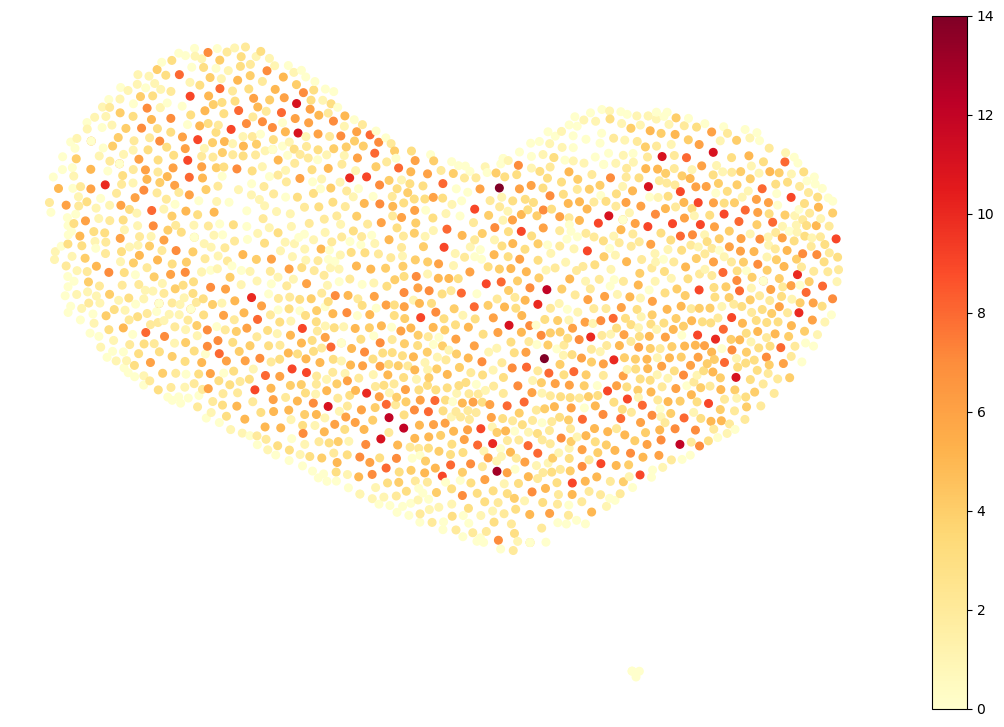

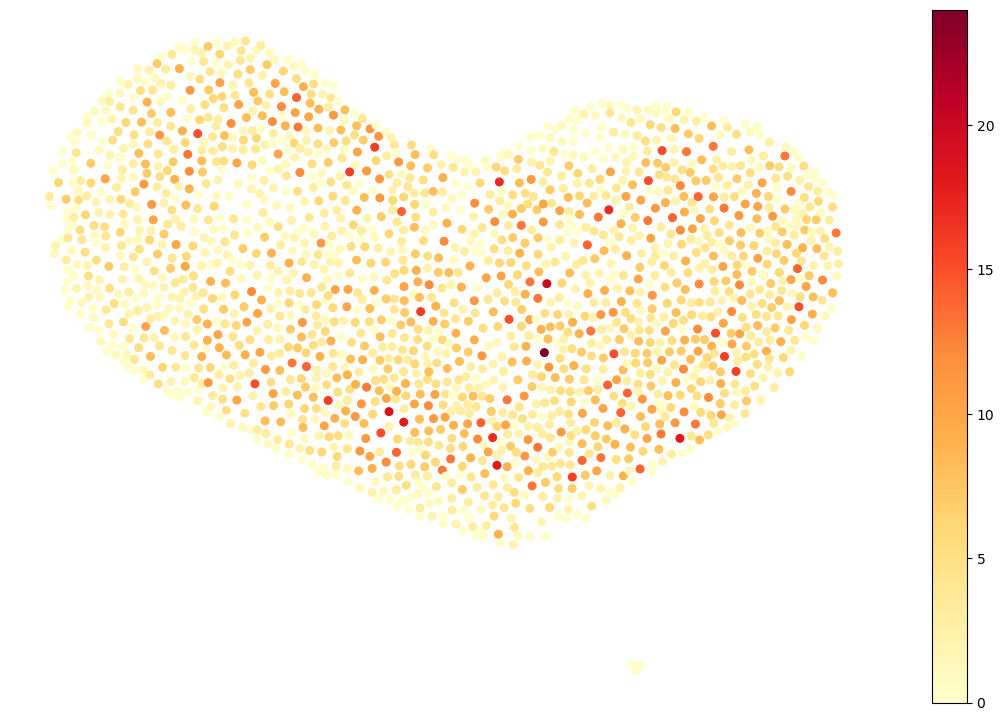

In [318]:
# df1 = find_mol_in_cells(need_recount=False)
# df2 = find_mol_in_cells(need_recount=True)

# строим график экспресии в генах
plot_expr(df1)
plot_expr(df2)

# df1_shift = mf_shift(df1)
# df2_shift = mf_shift(df2)

# df1_bands = find_bands(df1_shift)
# df2_bands = find_bands(df2_shift)

In [32]:
df1_mean = df1_bands.groupby('band').mean()
df2_mean = df2_bands.groupby('band').mean()

plt.figure(figsize=(10, 4))

plt.plot(df1_mean.index, df1_mean['mol_count'], label='До пересчета')
plt.plot(df2_mean.index, df2_mean['mol_count'], label='После пересчета')
plt.legend()
plt.xlabel('Номер полосы')
plt.ylabel('Среднее число мРНК')
plt.show()

NameError: name 'df1_bands' is not defined

### Попытки статистически подтвердить наличие пика

In [1]:
n_clusters = 3
gene = 'DI'
bins = 89

In [4]:
df_mol = pd.read_csv(fr"C:\Eyedisks\M1\-{gene}-qnd-mol.csv")
data = np.array(df_mol[f'{gene}mol_median'])

In [253]:
import numpy as np
from scipy import stats
from scipy.stats import kstest
from scipy.stats import lognorm

# Вычисляем параметры логнормального распределения по данным
shape, loc, scale = lognorm.fit(data)

# Выполняем тест Колмогорова-Смирнова
D, p = kstest(data, 'lognorm', args=(shape, loc, scale))

# Выводим результаты теста
print(f"Статистика теста Колмогорова-Смирнова: D = {D}, p-value = {p}")

Статистика теста Колмогорова-Смирнова: D = 0.04870116124047258, p-value = 2.11836334318227e-18


In [254]:
import numpy as np
from scipy import stats

# Выполним тест на нормальность
statistic, p_value = stats.normaltest(data)

# Выведем результаты теста
print("Результаты теста на нормальность:")
print(f"Статистика теста: {statistic}")
print(f"p-значение: {p_value}")

# Определим уровень значимости
alpha = 0.05

# Проверим, являются ли данные нормально распределенными
if p_value < alpha:
    print("Данные не являются нормально распределенными")
else:
    print("Данные являются нормально распределенными")

Результаты теста на нормальность:
Статистика теста: 3527.9659437971964
p-значение: 0.0
Данные не являются нормально распределенными


Параметры компонент:
Компонента 1:
Среднее: 27.15609651280915
Ковариация: 45.53588654600529
Вес: 0.5267708865766741
Компонента 2:
Среднее: 45.341040626742014
Ковариация: 144.92825674734874
Вес: 0.3569520460629956
Компонента 3:
Среднее: 78.17456309840638
Ковариация: 763.4255002208506
Вес: 0.11627706736033104


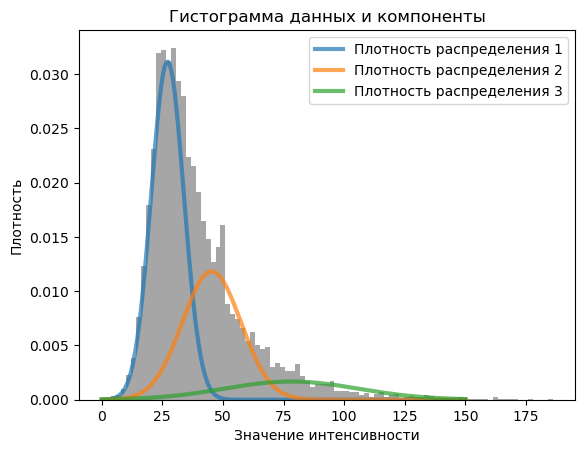

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Применим метод гауссовской смеси
# gmm = GaussianMixture(n_components=n_clusters, means_init=[[20], [50], [80]])
# gmm.fit(data.reshape(-1, 1))

# Получим параметры гауссовских компонент
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

x = np.linspace(0, 150, 1000)

# Выведем параметры компонент
print("Параметры компонент:")
for i in range(n_clusters):
    print(f"Компонента {i+1}:")
    print(f"Среднее: {means[i][0]}")
    print(f"Ковариация: {covariances[i][0][0]}")
    print(f"Вес: {weights[i]}")
    
    # Построим аппроксимацию гистограммы смесью гауссиан
    pdf = weights[i] * (1 / np.sqrt(2 * np.pi * covariances[i][0][0]) * np.exp(-(x - means[i][0]) ** 2 / (2 * covariances[i][0][0])))
    plt.plot(x, pdf,label=f'Плотность распределения {i + 1}', alpha=0.7, linewidth=3)

pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
plt.hist(data, bins=bins, density=True, alpha=0.7, color='gray')
# plt.plot(x, pdf, '-r', label='Гауссовская смесь')
plt.xlabel('Значение интенсивности')
plt.ylabel('Плотность')
plt.title('Гистограмма данных и компоненты')
plt.legend()
plt.show()

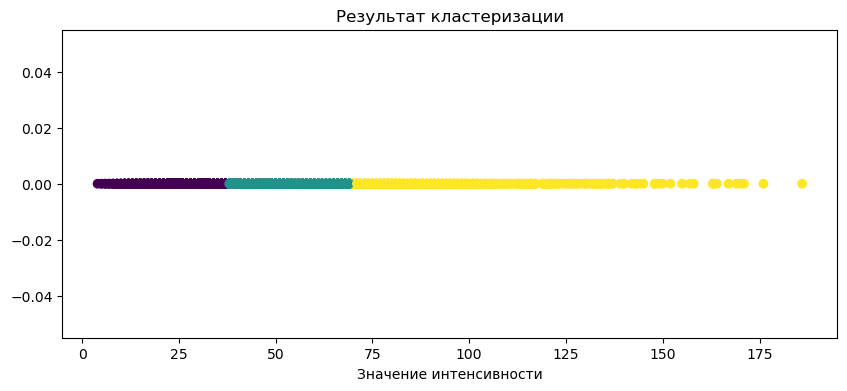

In [28]:
plt.figure(figsize=(10, 4))
plt.scatter(data, np.zeros_like(data), c=gmm.predict(data.reshape(-1, 1)))
plt.xlabel('Значение интенсивности')
plt.title('Результат кластеризации')
# ax = plt.gca()
# ax.set_xlim([10, 90])
plt.show()

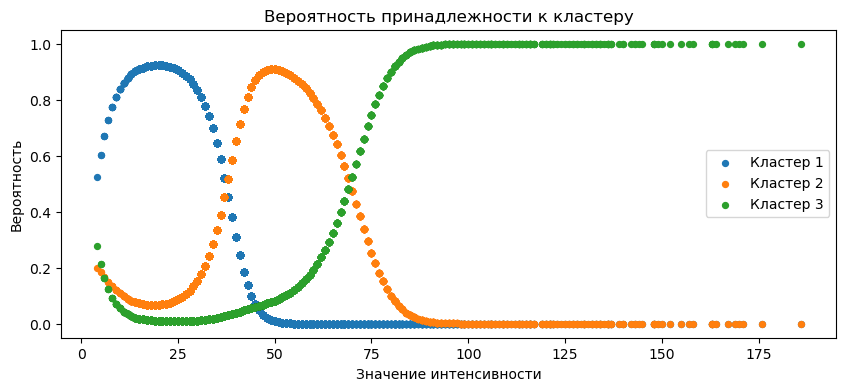

In [29]:
cluster_probs = gmm.predict_proba(data.reshape(-1, 1))

plt.figure(figsize=(10, 4))
# Постройте график вероятностей попадания точек в каждый кластер
for i in range(3):
    plt.scatter(data.reshape(-1, 1), cluster_probs[:, i], label=f'Кластер {i+1}', s=18)

    
plt.xlabel('Значение интенсивности')
plt.ylabel('Вероятность')
plt.title('Вероятность принадлежности к кластеру')
plt.legend()
plt.show()